In [174]:
##IMPORTING ALL THE LIBRARIES
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

import joblib

In [175]:
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')

In [176]:
# Reading the file 
brookdf = pd.read_csv('BrooklynDataFinal.csv', index_col=[0])
brookdf.head()

,Borough,Neighborhood,Building_Class_Category,Tax Class At Present,Block,Lot,Ease-Ment,Building Class At Present,address,Apartment Number,...,Total Units,Land_Square_Feet,Gross Square Feet,Year Built,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,sale date,latitude,longitude
9,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6399,8,NaN,S1,1653 BATH AVENUE,NaN,...,2.0,"1,260","1,440",1930.0,1,S1,800000.0,3/31/2022,40.605737,-74.008802
10,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6399,107,NaN,S1,1655 BATH AVENUE,NaN,...,2.0,"1,260","1,440",1930.0,1,S1,0.0,2/2/2022,40.605705,-74.008751
12,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6405,148,NaN,S1,1865 BATH AVENUE,NaN,...,2.0,"1,124","1,800",1920.0,1,S1,955000.0,10/28/2022,40.602952,-74.003951
16,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6442,32,NaN,S1,2014 BATH AVENUE,NaN,...,2.0,"1,245","1,596",1925.0,1,S1,0.0,7/25/2022,40.601019,-74.001314
21,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6461,141,NaN,A5,1173 SHORE PARKWAY,NaN,...,1.0,"1,661","1,392",1950.0,1,A5,843000.0,5/19/2022,40.602597,-74.012745


In [177]:
brookdf.shape

(7815, 23)

In [178]:
#Data Clean up

In [179]:
brookdf['Sale_Price'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])

0.000            0.0
0.250            0.0
0.500       597500.0
0.750      1400000.0
0.900      2800000.0
0.950      4500000.0
0.990     15750000.0
0.997     36746400.0
1.000    228447600.0
Name: Sale_Price, dtype: float64

In [180]:
brookdf['Year Built'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])

0.000    1800.000
0.250    1910.000
0.500    1925.000
0.750    1935.000
0.900    1987.000
0.950    2005.000
0.990    2019.000
0.997    2021.134
1.000    2022.000
Name: Year Built, dtype: float64

In [181]:
#Masking the data where the year built is less than 1900 and sale price is less than 100000 and more than 1e7
mask = (brookdf['Year Built'] > 1900) & (brookdf['Sale_Price'] > 100000) & (brookdf['Sale_Price'] < 1e7)
brookdf = brookdf[mask]

In [182]:
brookdf.shape

(3522, 23)

In [183]:
# Feature Engineering
#It appears that there are a substantial amount of missing values in a majority of the columns.
#To address this issue a 50% missing value cutoff. Columns that exceed this threshold will be removed.
req_cols = []

for col in brookdf.columns:
    is_na = round(brookdf[col].isna().sum() / len(brookdf) * 100, 2)
    if is_na < 50:
        req_cols.append(col)
    print(f"{col} has {is_na} % of nan values")

print(f"{len(req_cols)} has less than 50% of nan values")
brookdf = brookdf[req_cols]
print(brookdf.shape)

Borough has 0.0 % of nan values
Neighborhood has 0.0 % of nan values
Building_Class_Category has 0.0 % of nan values
Tax Class At Present has 0.0 % of nan values
Block has 0.0 % of nan values
Lot has 0.0 % of nan values
Ease-Ment has 100.0 % of nan values
Building Class At Present has 0.0 % of nan values
address has 0.0 % of nan values
Apartment Number has 99.83 % of nan values
Zip Code has 0.0 % of nan values
Residential_Units has 0.2 % of nan values
Commercial_Units has 0.03 % of nan values
Total Units has 0.03 % of nan values
Land_Square_Feet has 0.2 % of nan values
Gross Square Feet has 0.2 % of nan values
Year Built has 0.0 % of nan values
Tax_Class_At_Time_Of_Sale has 0.0 % of nan values
Building_Class_At_Time_Of_Sale has 0.0 % of nan values
Sale_Price has 0.0 % of nan values
sale date has 0.0 % of nan values
latitude has 0.31 % of nan values
longitude has 0.31 % of nan values
21 has less than 50% of nan values
(3522, 21)


In [184]:
### Categorical Columns
cat_cols = brookdf.select_dtypes('object').columns
k = 0
cardinality_cols = []

for col in cat_cols:
    value_counts = brookdf[col].value_counts(normalize=True).round(2)
    if len(value_counts) > 5 or len(value_counts) < 2:
        cardinality_cols.append(col)
    else:
        print("====================================================================")
        print(col)
        print(value_counts)

cardinality_cols.remove('Neighborhood')
cardinality_cols.remove('Building_Class_At_Time_Of_Sale')
print(f"Removed Columns: {cardinality_cols}")
brookdf.drop(columns=cardinality_cols, axis=1, inplace=True)

Removed Columns: ['Building_Class_Category', 'Tax Class At Present', 'Building Class At Present', 'address', 'Land_Square_Feet', 'Gross Square Feet', 'sale date']


In [185]:
#Checking and normalizing the Neighborhoods
brookdf['Neighborhood'].value_counts(normalize=True).round(2)

EAST NEW YORK               0.08
BUSHWICK                    0.08
BEDFORD STUYVESANT          0.06
CROWN HEIGHTS               0.05
FLATBUSH-EAST               0.04
CANARSIE                    0.04
BAY RIDGE                   0.03
CYPRESS HILLS               0.03
MARINE PARK                 0.03
GREENPOINT                  0.03
SHEEPSHEAD BAY              0.03
WILLIAMSBURG-EAST           0.03
GRAVESEND                   0.03
BROWNSVILLE                 0.03
FLATBUSH-CENTRAL            0.02
GERRITSEN BEACH             0.02
OCEAN HILL                  0.02
FLATBUSH-NORTH              0.02
OCEAN PARKWAY-SOUTH         0.02
MADISON                     0.02
OCEAN PARKWAY-NORTH         0.02
WYCKOFF HEIGHTS             0.02
PARK SLOPE                  0.02
MIDWOOD                     0.02
FLATBUSH-LEFFERTS GARDEN    0.01
BOROUGH PARK                0.01
BENSONHURST                 0.01
MILL BASIN                  0.01
BERGEN BEACH                0.01
BRIGHTON BEACH              0.01
SUNSET PAR

In [186]:
#Normalizing the neghborhood data
neighborhood = brookdf['Neighborhood'].value_counts(normalize=True).round(2)
idx = np.where(neighborhood > 0.01)[0].max()
places = neighborhood.index[:idx]
brookdf['Neighborhood'] =brookdf['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
brookdf['Neighborhood'].value_counts(normalize=True)

OTHER                  0.238217
EAST NEW YORK          0.081204
BUSHWICK               0.077513
BEDFORD STUYVESANT     0.057638
CROWN HEIGHTS          0.046281
FLATBUSH-EAST          0.042022
CANARSIE               0.035775
BAY RIDGE              0.034923
CYPRESS HILLS          0.034639
MARINE PARK            0.032368
SHEEPSHEAD BAY         0.030380
GREENPOINT             0.030380
WILLIAMSBURG-EAST      0.027257
GRAVESEND              0.025554
BROWNSVILLE            0.025270
GERRITSEN BEACH        0.022714
FLATBUSH-CENTRAL       0.022714
OCEAN HILL             0.022430
FLATBUSH-NORTH         0.021863
OCEAN PARKWAY-SOUTH    0.020159
MADISON                0.019591
OCEAN PARKWAY-NORTH    0.017604
WYCKOFF HEIGHTS        0.017036
PARK SLOPE             0.016468
Name: Neighborhood, dtype: float64

In [187]:
#Normalizing Building class
building_class = brookdf['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
idx = np.where(building_class > 0.01)[0].max()
places = building_class.index[:idx]
brookdf['Building_Class_At_Time_Of_Sale'] =brookdf['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
brookdf['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True)

OTHER    0.187394
B1       0.133731
C0       0.131175
A5       0.089722
B2       0.074673
A1       0.069563
B3       0.063884
B9       0.059057
A9       0.051107
S2       0.044293
C3       0.033504
C2       0.032936
C1       0.028961
Name: Building_Class_At_Time_Of_Sale, dtype: float64

In [188]:
brookdf.shape

(3522, 14)

In [189]:
#Removed low variance columns
num_cols = brookdf.select_dtypes('number').columns

low_var_cols = []
for col in num_cols:
    scaled = (brookdf[col] - brookdf[col].mean()) / brookdf[col].std()
    variance = scaled.var()
    if variance == 0 or brookdf[col].std() == 0:
        low_var_cols.append(col)
#     else:
#         print(col, variance)

brookdf.drop(columns=low_var_cols, axis=1, inplace=True)
print(f"Removed Columns: {low_var_cols}")
print(brookdf.shape, len(low_var_cols))

Removed Columns: ['Borough']
(3522, 13) 1


In [190]:
#Gathering age when the building was built
brookdf['age'] = 2023 - (brookdf['Year Built'] + brookdf['Year Built']) // 2
brookdf.drop(['Zip Code', 'Year Built'], axis=1, inplace=True)

In [191]:
#corrleation between saleprice and other columns and number of features by dropping correlated independent features
corr = brookdf.drop('Sale_Price', axis=1).corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
print(f"columns dropped are: {drop}")
brookdf.drop(columns=drop, axis=1, inplace=True)

columns dropped are: ['Total Units', 'latitude']


C:\Users\seema\AppData\Local\Temp\ipykernel_2756\21742755.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


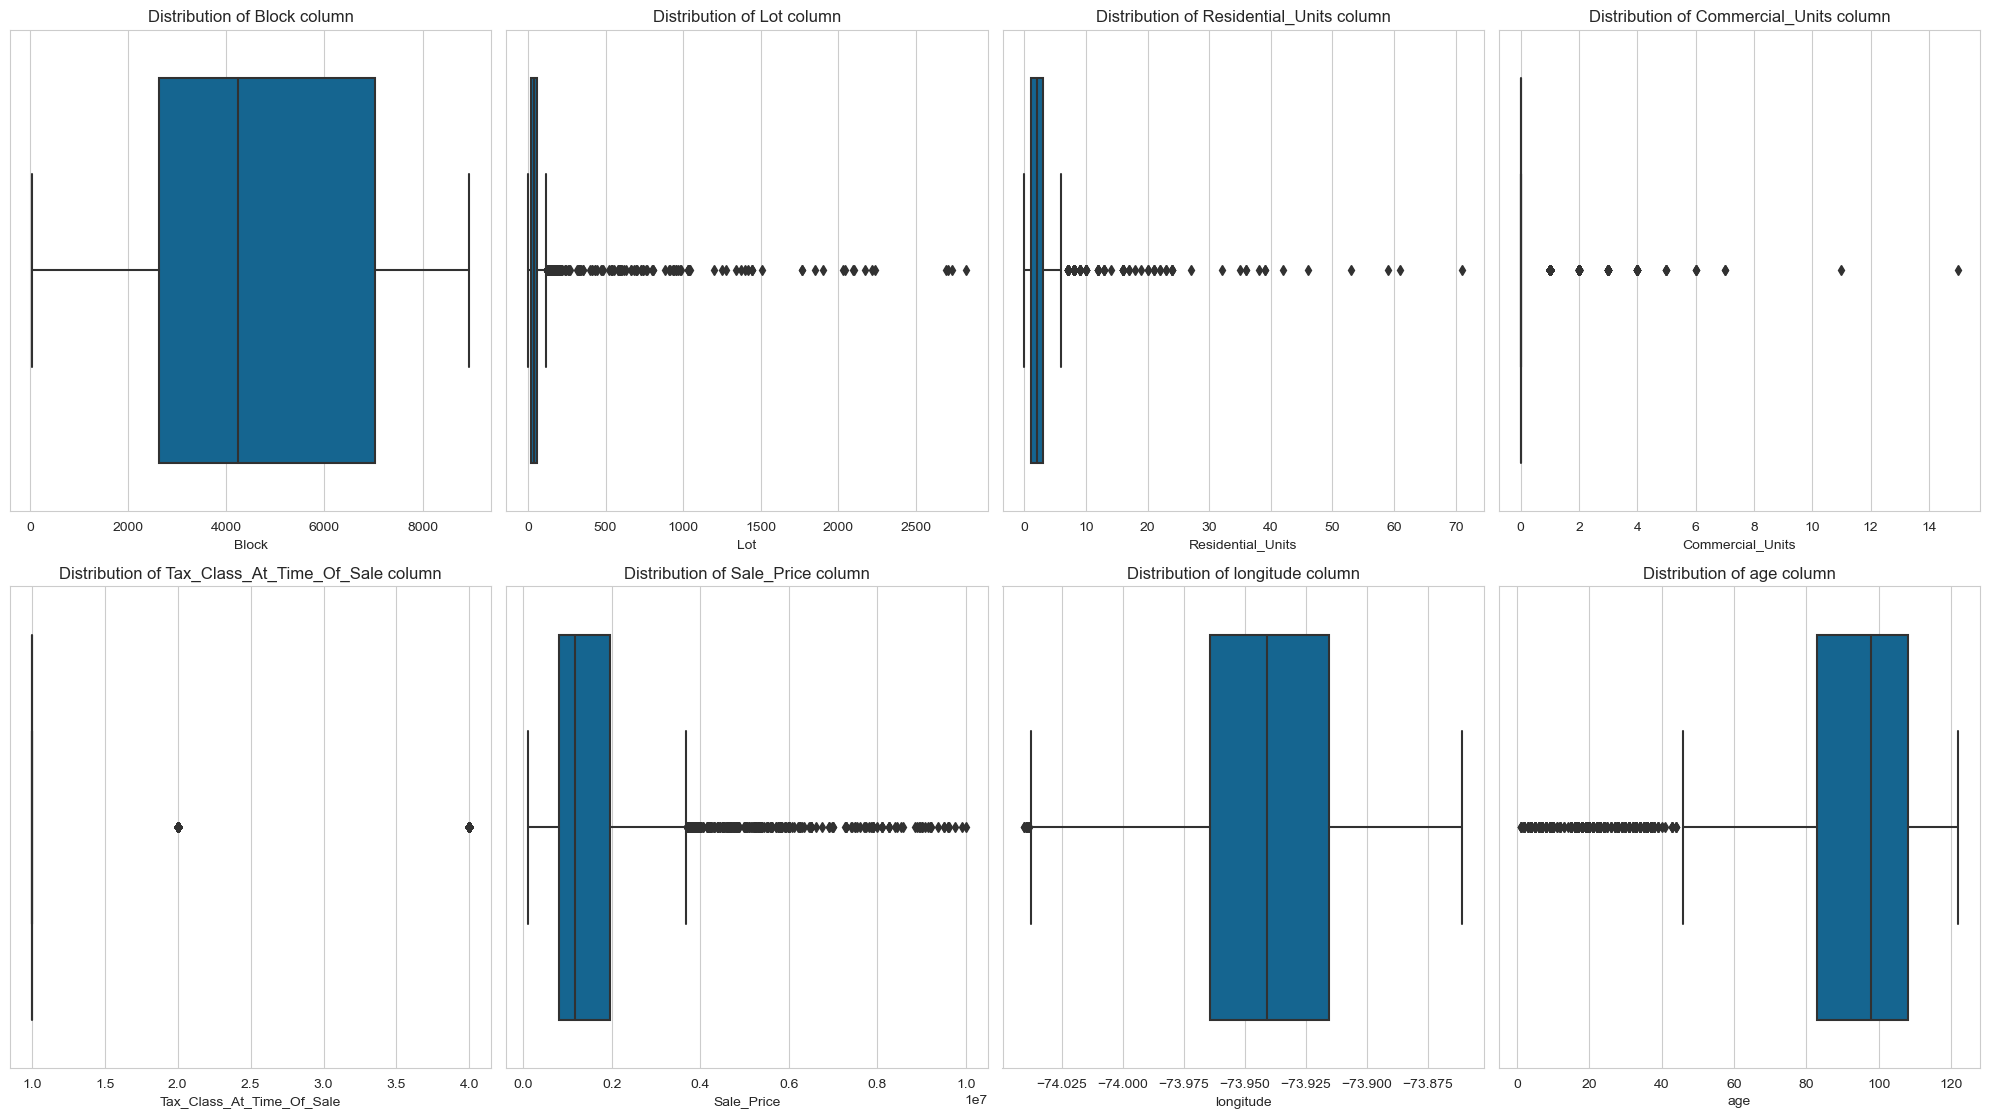

In [192]:
#data Distribution using BoxPlot
num_cols = brookdf.select_dtypes('number').columns
k = 0
plt.figure(figsize=(20, 100))
for col in num_cols:
    plt.subplot(18, 4, k + 1)
    sns.boxplot(data=brookdf, x=col)
    plt.xlabel(col)
    plt.title(f"Distribution of {col} column")
    k += 1
plt.tight_layout()

<AxesSubplot:>

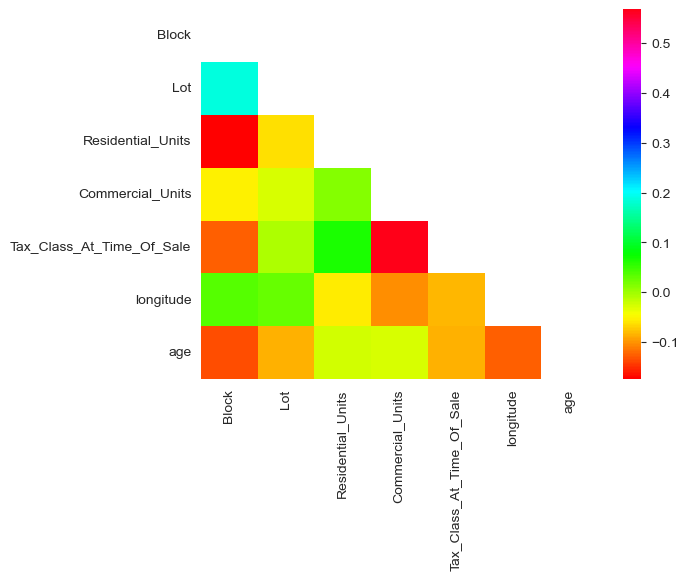

In [193]:
#correlation map
corr = brookdf.drop('Sale_Price', axis=1).corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap='hsv')

In [194]:
brookdf.shape

(3522, 10)

In [195]:
brookdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3522 entries, 9 to 25607
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    3522 non-null   object 
 1   Block                           3522 non-null   int64  
 2   Lot                             3522 non-null   int64  
 3   Residential_Units               3515 non-null   float64
 4   Commercial_Units                3521 non-null   float64
 5   Tax_Class_At_Time_Of_Sale       3522 non-null   int64  
 6   Building_Class_At_Time_Of_Sale  3522 non-null   object 
 7   Sale_Price                      3522 non-null   float64
 8   longitude                       3511 non-null   float64
 9   age                             3522 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 302.7+ KB


In [196]:
drop_cols = ['Block', 'Lot']
brookdf.drop(columns=drop_cols, axis=1, inplace=True)

In [197]:
brookdf.shape

(3522, 8)

In [198]:
brookdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3522 entries, 9 to 25607
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    3522 non-null   object 
 1   Residential_Units               3515 non-null   float64
 2   Commercial_Units                3521 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       3522 non-null   int64  
 4   Building_Class_At_Time_Of_Sale  3522 non-null   object 
 5   Sale_Price                      3522 non-null   float64
 6   longitude                       3511 non-null   float64
 7   age                             3522 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 247.6+ KB


In [199]:
brookdf.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 9 to 25607
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    3506 non-null   object 
 1   Residential_Units               3506 non-null   float64
 2   Commercial_Units                3506 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       3506 non-null   int64  
 4   Building_Class_At_Time_Of_Sale  3506 non-null   object 
 5   Sale_Price                      3506 non-null   float64
 6   longitude                       3506 non-null   float64
 7   age                             3506 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 246.5+ KB


In [200]:
brookdf.dropna(inplace=True)

In [201]:
brookdf.shape

(3506, 8)

In [202]:
#wrangle function
def treat_categorical(brookdf):
    cat_cols = brookdf.select_dtypes('object').columns
    k = 0
    cardinality_cols = []
    for col in cat_cols:
        value_counts = brookdf[col].value_counts(normalize=True).round(2)
        if len(value_counts) > 5 or len(value_counts) < 2:
            cardinality_cols.append(col)
    return cardinality_cols

def get_low_variance_cols(brookdf):
    num_cols = brookdf.drop('Sale_Price', axis=1).select_dtypes('number').columns
    low_var_cols = []
    for col in num_cols:
        scaled = (brookdf[col] - brookdf[col].mean()) / brookdf[col].std()
        variance = scaled.var().round(2)
        if variance == 0 or brookdf[col].std() == 0:
            low_var_cols.append(col)
    return low_var_cols

def treat_na(brookdf):
    req_cols = []
    for col in brookdf.columns:
        is_na = round(brookdf[col].isna().sum() / len(brookdf) * 100, 2)
        if is_na < 50:
            req_cols.append(col)
    return req_cols
def wrangle(filepath):
    # Import data
    brookdf = pd.read_csv(filepath, index_col=[0])
    print(f"Imported Data, Shape: {brookdf.shape}")
    
    # Filter out the relevant data by sale_price and year_built
    mask = (brookdf['Year Built'] > 1900) & (brookdf['Sale_Price'] > 100000) & (brookdf['Sale_Price'] < 1e7)
    brookdf = brookdf[mask]
    print(f"Created mask, Shape: {brookdf.shape}")
    
    # Remove features which have majority missing values
    req_cols = treat_na(brookdf)
    brookdf = brookdf[req_cols]
    print(f"Filtered Columns by NaN, Shape: {brookdf.shape}")
    
    # Remove high and low cardinality categorical columns
    drop_cols = treat_categorical(brookdf)
    if 'Neighborhood' in drop_cols:
        drop_cols.remove('Neighborhood')
    if 'Building_Class_At_Time_Of_Sale' in drop_cols:
        drop_cols.remove('Building_Class_At_Time_Of_Sale')
    brookdf.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns by Cardinality, Shape: {brookdf.shape}")
    
    # Reduce the cardinality of neighborhood column
    neighborhood = brookdf['Neighborhood'].value_counts(normalize=True).round(2)
    idx = np.where(neighborhood > 0.01)[0].max()
    places = neighborhood.index[:idx]
    brookdf['Neighborhood'] =brookdf['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
    
    # Reduce the cardinality of building_class_at_sale column
    building_class = brookdf['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
    idx = np.where(building_class > 0.01)[0].max()
    places = building_class.index[:idx]
    brookdf['Building_Class_At_Time_Of_Sale'] =brookdf['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
    
    
    # Calculate age of the house
    brookdf['age'] = 2023 - (brookdf['Year Built'] + brookdf['Year Built']) // 2
    
    # Drop unwanted columns
    drop = ['Zip Code', 'Year Built']
    brookdf.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by redundancy, Shape: {brookdf.shape}")
    
    # Drop columns with multicollinearity
    corr = brookdf.drop('Sale_Price', axis=1).corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
    brookdf.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by collinearity, Shape: {brookdf.shape}")
    
    # Drop unwanted columns
    drop_cols = ['Block', 'Lot']
    brookdf.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns manually, Shape: {brookdf.shape}")
    
    # Drop missing values
    brookdf.dropna(inplace=True)
    print(f"Dropped NaN values, Shape: {brookdf.shape}")
    
    return brookdf

In [203]:
brookdf.shape

(3506, 8)

In [204]:
brookdf.info

<bound method DataFrame.info of           Neighborhood  Residential_Units  Commercial_Units  \
9                OTHER                1.0               1.0   
12               OTHER                1.0               1.0   
21               OTHER                1.0               0.0   
26               OTHER                1.0               0.0   
61               OTHER                2.0               0.0   
...                ...                ...               ...   
25600  WYCKOFF HEIGHTS                0.0               1.0   
25601  WYCKOFF HEIGHTS                0.0               1.0   
25604  WYCKOFF HEIGHTS                0.0               1.0   
25605  WYCKOFF HEIGHTS                0.0               1.0   
25607  WYCKOFF HEIGHTS                0.0               0.0   

       Tax_Class_At_Time_Of_Sale Building_Class_At_Time_Of_Sale  Sale_Price  \
9                              1                          OTHER    800000.0   
12                             1                     

In [205]:
Brooklyn = wrangle('BrooklynDataFinal.csv')
print(Brooklyn.shape)
Brooklyn.head()

Imported Data, Shape: (7815, 23)
Created mask, Shape: (3522, 23)
Filtered Columns by NaN, Shape: (3522, 21)
Dropped Columns by Cardinality, Shape: (3522, 14)
Dropped Columns by redundancy, Shape: (3522, 13)
Dropped Columns by collinearity, Shape: (3522, 11)
Dropped Columns manually, Shape: (3522, 9)
Dropped NaN values, Shape: (3506, 9)
(3506, 9)


C:\Users\seema\AppData\Local\Temp\ipykernel_2756\2540135087.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


,Borough,Neighborhood,Residential_Units,Commercial_Units,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,longitude,age
9,3,OTHER,1.0,1.0,1,OTHER,800000.0,-74.008802,93.0
12,3,OTHER,1.0,1.0,1,OTHER,955000.0,-74.003951,103.0
21,3,OTHER,1.0,0.0,1,A5,843000.0,-74.012745,73.0
26,3,OTHER,1.0,0.0,1,A5,880000.0,-74.013811,78.0
61,3,OTHER,2.0,0.0,1,B2,1388000.0,-74.001930,93.0


In [206]:
#Data Visualization
Brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 9 to 25607
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Borough                         3506 non-null   int64  
 1   Neighborhood                    3506 non-null   object 
 2   Residential_Units               3506 non-null   float64
 3   Commercial_Units                3506 non-null   float64
 4   Tax_Class_At_Time_Of_Sale       3506 non-null   int64  
 5   Building_Class_At_Time_Of_Sale  3506 non-null   object 
 6   Sale_Price                      3506 non-null   float64
 7   longitude                       3506 non-null   float64
 8   age                             3506 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 273.9+ KB


In [207]:
viz_df = Brooklyn.copy()

In [208]:
brookdf['Sale_Price'] = brookdf['Sale_Price'].astype(np.float64)
print(brookdf.dtypes)

Neighborhood                       object
Residential_Units                 float64
Commercial_Units                  float64
Tax_Class_At_Time_Of_Sale           int64
Building_Class_At_Time_Of_Sale     object
Sale_Price                        float64
longitude                         float64
age                               float64
dtype: object


In [209]:
median_home_price = viz_df['Sale_Price'].median()
median_home_price

1165000.0

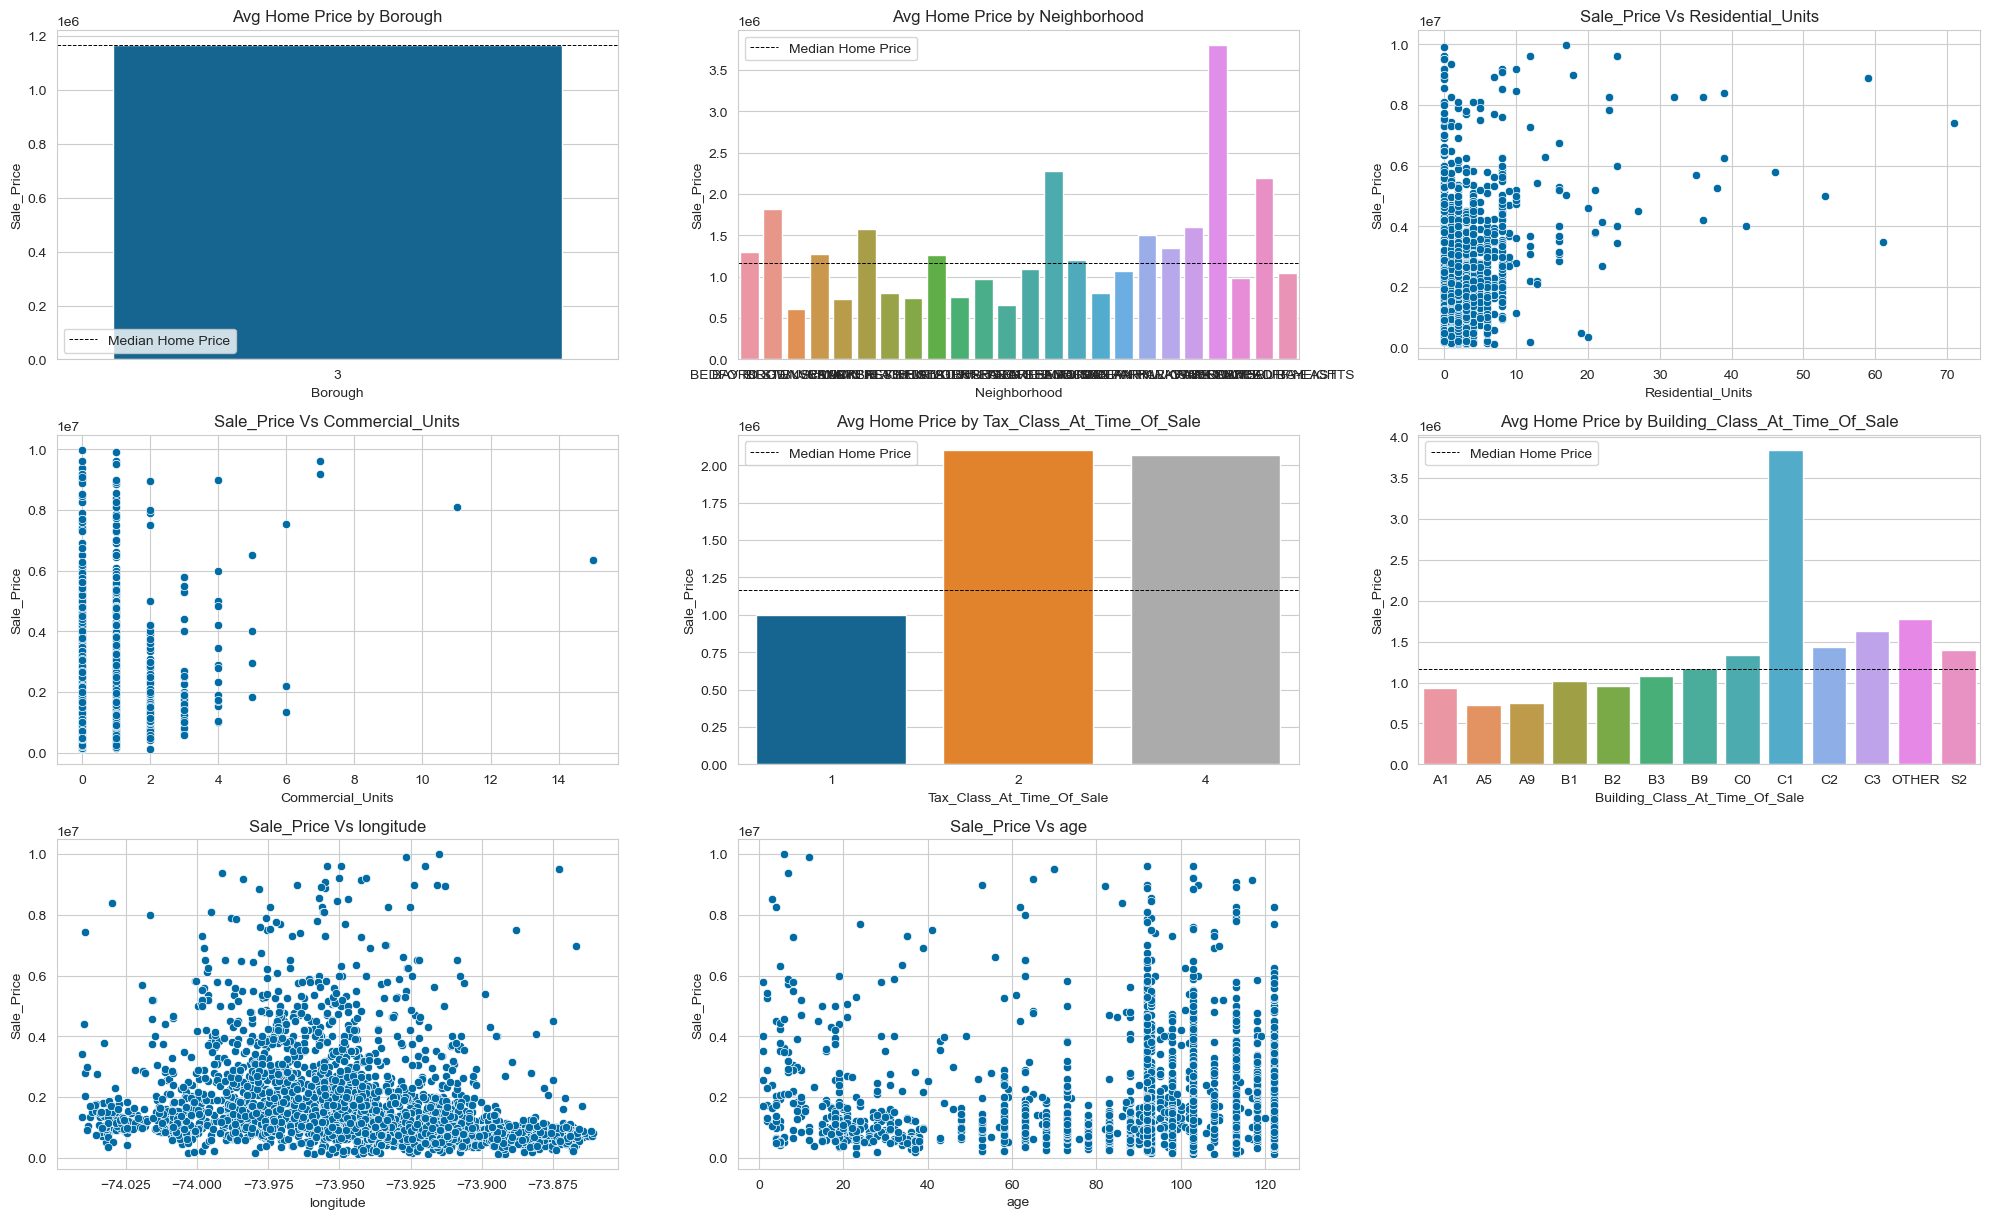

In [210]:
#plotting the original data
k = 0
plt.figure(figsize=(20, 20))
for col in viz_df.drop('Sale_Price', axis=1).columns:
    plt.subplot(5, 3, k + 1)
    if viz_df[col].dtype == 'float64':
        sns.scatterplot(data=viz_df, x=col, y='Sale_Price')
        plt.title(f"Sale_Price Vs {col}")
    else:
        group = viz_df[[col, 'Sale_Price']].groupby(by=col).median()
        sns.barplot(data=group, x=group.index, y='Sale_Price')
        plt.axhline(y=median_home_price, label='Median Home Price', color='black', linestyle='--', linewidth=0.7)
        plt.title(f"Avg Home Price by {col}")
        plt.legend()
    k += 1
plt.tight_layout()

In [241]:
 #house class C1 has a significantly higher sale price compared to other house classes

<AxesSubplot:xlabel='Sale_Price', ylabel='Count'>

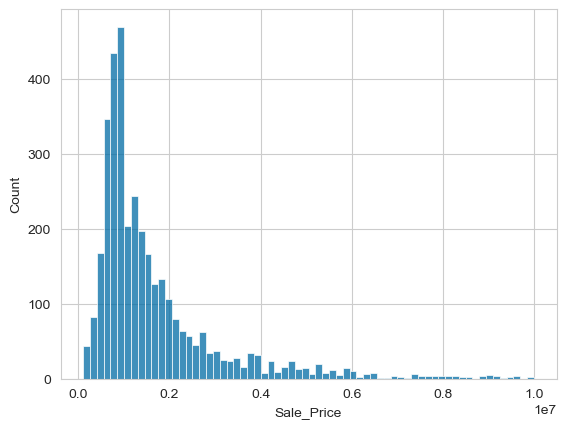

In [211]:
sns.histplot(viz_df['Sale_Price'])

<AxesSubplot:xlabel='Sale_Price', ylabel='Count'>

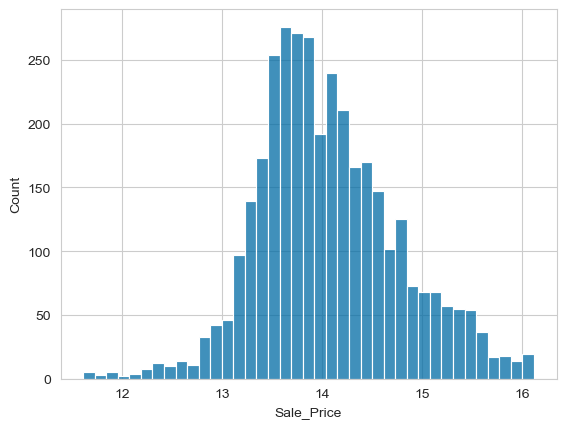

In [212]:
#Normalizing the Target Column for Improved Model Performance using log transformation effectively converts the target column to an approximately normal distribution.
sns.histplot(np.log(viz_df['Sale_Price']))


In [213]:
#Creating the trianing and test set
X_train, X_test, y_train, y_test = train_test_split(Brooklyn.drop('Sale_Price', axis=1), Brooklyn['Sale_Price'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2804, 8), (702, 8), (2804,), (702,))

In [214]:
X_train.columns

Index(['Borough', 'Neighborhood', 'Residential_Units', 'Commercial_Units',
       'Tax_Class_At_Time_Of_Sale', 'Building_Class_At_Time_Of_Sale',
       'longitude', 'age'],
      dtype='object')

In [215]:
#caluclating the RMSE
y_mean = Brooklyn['Sale_Price'].mean()
print("Baseline R2 Score:", r2_score(y_test, [y_mean] * len(y_test)))
print("Baseline Root Mean Squared Error:", mean_squared_error(y_test, [y_mean] * len(y_test), squared=False))

Baseline R2 Score: -0.0006508699128362494
Baseline Root Mean Squared Error: 1354178.5558621555


In [108]:
#RandomForestRegressor¶

In [216]:
def train_model(model):
    model.fit(X_train, np.log(y_train))
    print(f"Train R-Squared: {r2_score(y_train, np.exp(model.predict(X_train))).round(2)}")
    print(f"Test R-Squared: {r2_score(y_test, np.exp(model.predict(X_test))).round(2)}")
    print(f"Train Root Mean Squared Error: {mean_squared_error(y_train, np.exp(model.predict(X_train)), squared=False).round(2)}")
    print(f"Test Root Mean Squared Error: {mean_squared_error(y_test, np.exp(model.predict(X_test)), squared=False).round(2)}")
    return model

In [217]:
rf = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)
rf = train_model(rf)

Train R-Squared: 0.88
Test R-Squared: 0.46
Train Root Mean Squared Error: 507246.84
Test Root Mean Squared Error: 998322.9


In [218]:
#parameter tuning

params = {
    'randomforestregressor__n_estimators': np.arange(25, 126, 25),
    'randomforestregressor__min_samples_split': np.arange(2, 26, 5)
}
rf_grid = RandomizedSearchCV(
    estimator = rf,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_grid = train_model(rf_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train R-Squared: 0.69
Test R-Squared: 0.45
Train Root Mean Squared Error: 816336.73
Test Root Mean Squared Error: 999615.78


In [219]:
rf_grid.best_estimator_

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Neighborhood',
                                     'Building_Class_At_Time_Of_Sale'])),
                ('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_split=12, n_jobs=-1,
                                       random_state=42))])

In [ ]:
#XGBooster Model

In [220]:
xgb = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    XGBRegressor(random_state=42, n_jobs=-1),
)
xgb = train_model(xgb)

Train R-Squared: 0.86
Test R-Squared: 0.38
Train Root Mean Squared Error: 541187.39
Test Root Mean Squared Error: 1069777.83


In [114]:
#CatBoost Regressor

In [221]:
cat = CatBoostRegressor(
    cat_features=list(X_train.select_dtypes('object').columns),
    verbose=0
)
cat = train_model(cat)

Train R-Squared: 0.64
Test R-Squared: 0.43
Train Root Mean Squared Error: 886780.14
Test Root Mean Squared Error: 1020447.63


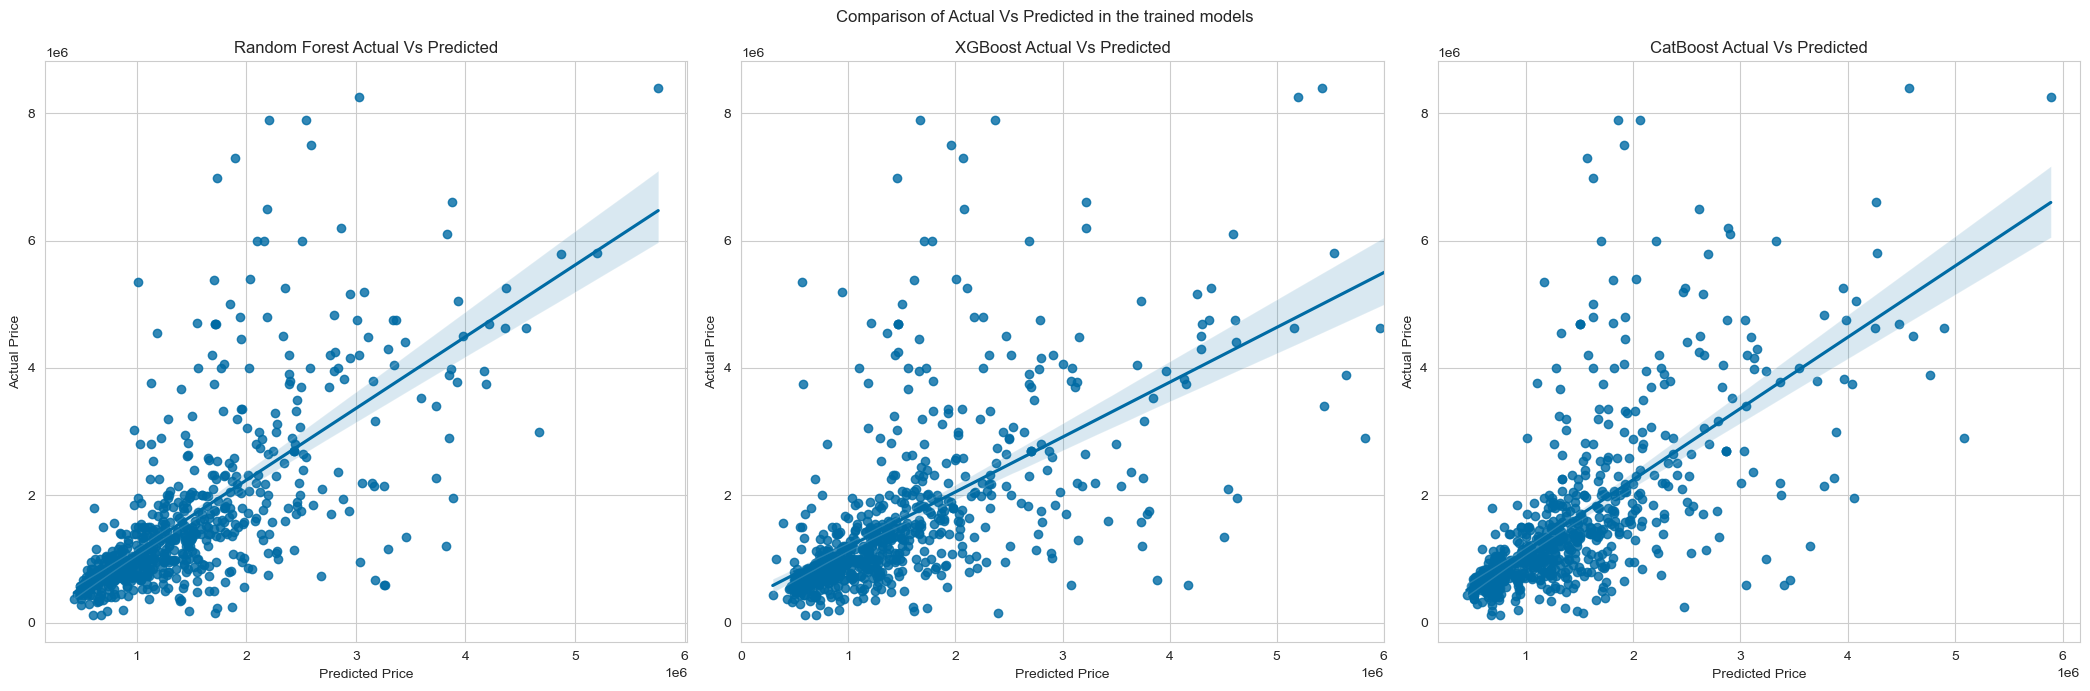

In [222]:
#Plots between different models and predictions and analysis

plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
preds = np.exp(rf_grid.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Actual Vs Predicted');

plt.subplot(1, 3, 2)
preds = np.exp(xgb.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlim(0, 6e6)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Actual Vs Predicted');

plt.subplot(1, 3, 3)
preds = np.exp(cat.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('CatBoost Actual Vs Predicted');

plt.suptitle('Comparison of Actual Vs Predicted in the trained models')
plt.tight_layout()


In [239]:
#XGGBoost and CatBoost models have generated results with a very close RMSE. RandomForest has closer train and test RMSE. So, Random Forest Regressor seems to be the best model in this situation.

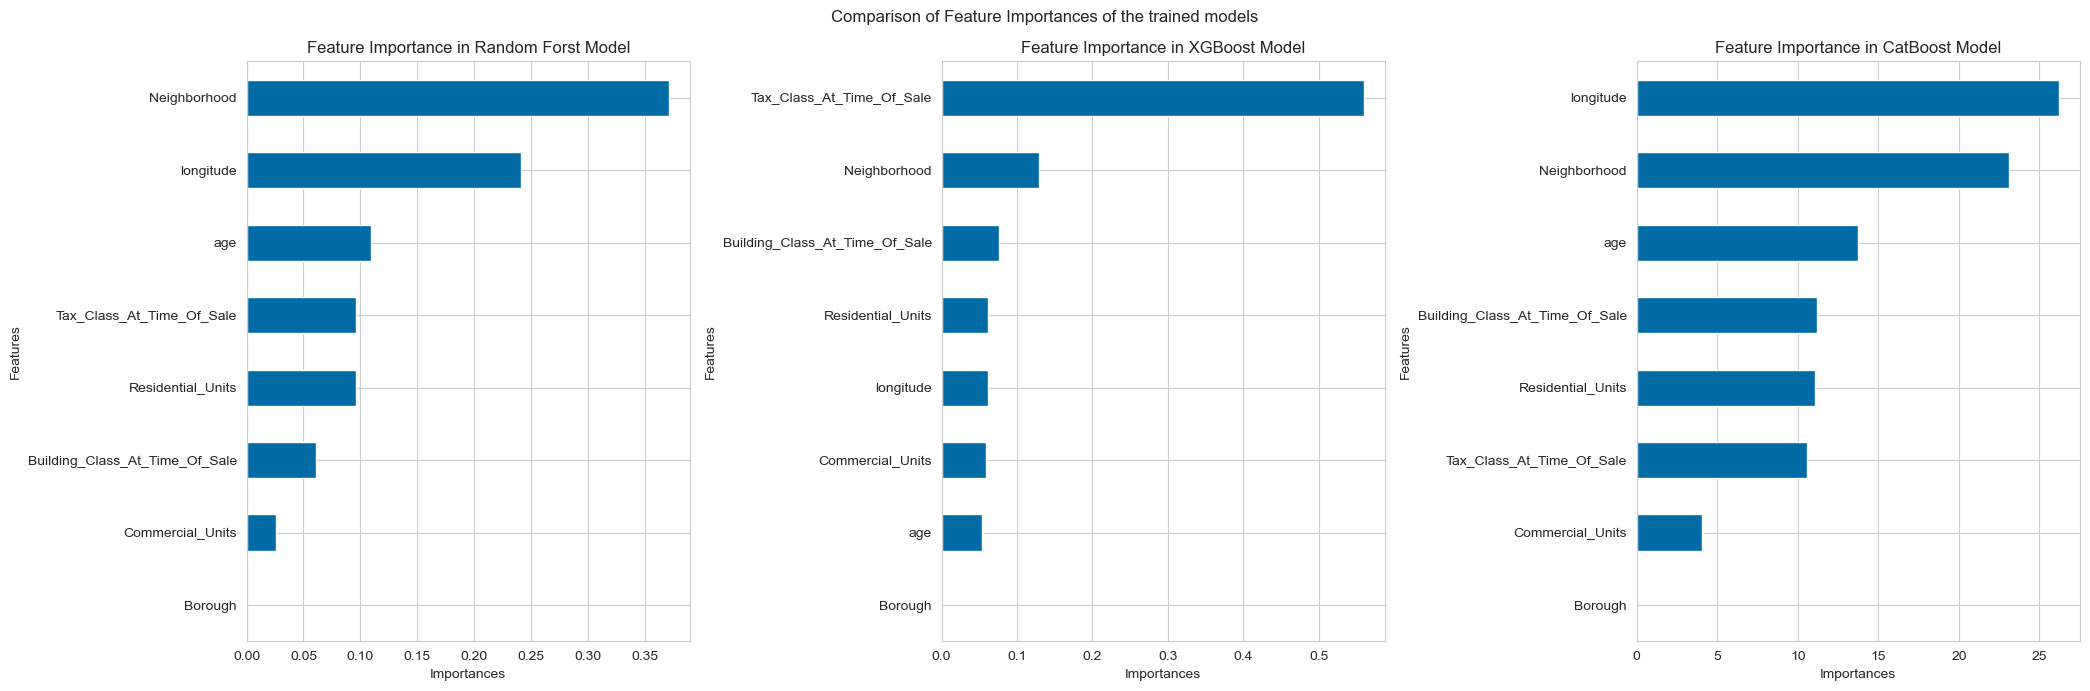

In [223]:
#plots to compare of features of the trained model
plt.figure(figsize=(21, 7))
feat_imp = rf_grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_
rf_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 1)
rf_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forst Model');

feat_imp = xgb.named_steps['xgbregressor'].feature_importances_
xgb_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 2)
xgb_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost Model');

feat_imp = cat.get_feature_importance()
cat_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 3)
cat_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost Model')

plt.suptitle('Comparison of Feature Importances of the trained models')
plt.tight_layout();

In [224]:
joblib.dump(rf_grid, 'randomforest.pkl', compress=9)

['randomforest.pkl']

In [225]:
joblib.dump(xgb, 'xgboost.pkl', compress=9)

['xgboost.pkl']

In [226]:
joblib.dump(cat, 'catboost.pkl', compress=9)

['catboost.pkl']

In [231]:
def predict_house_price(Borough, Neighborhood, Residential_Units, Commercial_Units,
       Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       latitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Commercial_Units': Commercial_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'latitude': latitude,
        'age': age
    }
    
    brookdf = pd.DataFrame(params_dict, index=[0])
    
    with open('randomforest.pkl', 'rb') as f:
        rf_grid = joblib.load(f)
        
    rf_grid_pred = rf_grid.predict(brookdf)
    
    avg = (np.exp(rf_grid_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [232]:
predict_house_price(
    Borough = 3,
    Neighborhood = "BATH BEACH",
    Residential_Units = 1, 
    Commercial_Units = 1,
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'S1',
    latitude = 40.6029517,
    age = 103
)

C:\Users\seema\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- latitude
Feature names seen at fit time, yet now missing:
- longitude

  warnings.warn(message, FutureWarning)


'The Predicted House Price is $1053100.22'

In [237]:
def predict_house_price(Borough, Neighborhood, Residential_Units, Commercial_Units,
       Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       latitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Commercial_Units': Commercial_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'latitude': latitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('xgboost.pkl', 'rb') as f:
        xgb = joblib.load(f)
        
    xgb_pred = xgb.predict(brookdf)
    
    avg = (np.exp(xgb_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [238]:
predict_house_price(
    Borough = 3,
    Neighborhood = "BATH BEACH",
    Residential_Units = 1, 
    Commercial_Units = 1,
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'S1',
    latitude = 40.6029517,
    age = 103
)

C:\Users\seema\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Sale_Price
Feature names seen at fit time, yet now missing:
- Borough

  warnings.warn(message, FutureWarning)


'The Predicted House Price is $2104829.0'